# Tennis - Multi Agent

In [1]:
from unityagents import UnityEnvironment

import numpy as np

In [2]:
env = UnityEnvironment(file_name="environments/Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# reset the environment
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print(states[0].shape)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]
(24,)


## Train Agent

In [4]:
env_info = env.reset(train_mode=True)[brain_name]

In [5]:
action_size = brain.vector_action_space_size
states = env_info.vector_observations
state_size = states.shape[1]
print(state_size)

24


In [6]:
import matplotlib.pyplot as plt
import torch

from ddpg_agent import Agent
from collections import deque

agent_1 = Agent(state_size, action_size, random_seed=42)
agent_2 = Agent(state_size, action_size, random_seed=42)


def ddpg_double_agent(env, agent_1, agent_2, num_episodes=5000, optimum_score=0.5):
    scores = []
    scores_window = deque(maxlen=100)  # last 100 scores
    for i_episode in range(1, num_episodes + 1):
        agent_1.reset()
        agent_1.reset()
        score = np.zeros(2)

        env_info = env.reset(train_mode=True)[brain_name]
        state = np.reshape(env_info.vector_observations, (1,48))
        while True:

            action_1 = agent_1.act(state, add_noise=True)
            action_2 = agent_2.act(state, add_noise=True)

            actions = np.concatenate((action_1, action_2), axis=0).flatten()
            env_info = env.step(actions)[brain_name]
            next_state = np.reshape(env_info.vector_observations, (1,48))
            rewards = env_info.rewards
            dones = env_info.local_done

            score += rewards

            agent_1.step(state, actions, rewards[0], next_state, dones[0], 1)
            agent_2.step(state, actions, rewards[1], next_state, dones[1], 2)

            state = next_state

            if np.any(dones):
                break
                
        scores_window.append(score)       # save most recent score
        scores.append(score)
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

        if np.mean(scores_window) >= optimum_score:
            print("\t Environment is solved in {} episodes!".format(i_episode))
            break

    torch.save(agent_1.actor_local.state_dict(), "actor_checkpoint_1.pth")
    torch.save(agent_1.critic_local.state_dict(), "critic_checkpoint_1.pth")

    torch.save(agent_2.actor_local.state_dict(), "actor_checkpoint_2.pth")
    torch.save(agent_2.critic_local.state_dict(), "critic_checkpoint_2.pth")

    return scores

In [7]:
scores = ddpg_double_agent(env, agent_1, agent_2)

Episode 100	Average Score: 0.02
Episode 200	Average Score: 0.01
Episode 300	Average Score: -0.00
Episode 400	Average Score: 0.01
Episode 500	Average Score: 0.01
Episode 600	Average Score: 0.01
Episode 700	Average Score: 0.01
Episode 800	Average Score: 0.02
Episode 900	Average Score: 0.03
Episode 1000	Average Score: 0.05
Episode 1100	Average Score: 0.05
Episode 1200	Average Score: 0.05
Episode 1300	Average Score: 0.06
Episode 1400	Average Score: 0.06
Episode 1500	Average Score: 0.08
Episode 1600	Average Score: 0.11
Episode 1700	Average Score: 0.15
Episode 1800	Average Score: 0.15
Episode 1900	Average Score: 0.16
Episode 2000	Average Score: 0.17
Episode 2100	Average Score: 0.30
Episode 2200	Average Score: 0.35
Episode 2300	Average Score: 0.45
	 Environment is solved in 2392 episodes!


In [12]:
np.mean(scores[-100:])

0.5014500076789409

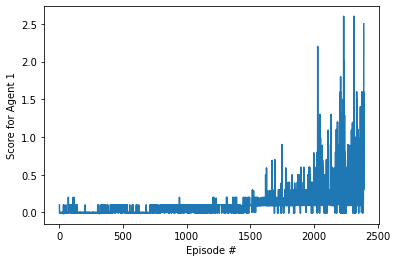

In [17]:
sc1 = [i[0] for i in scores]
sc2 = [i[1] for i in scores]
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(sc1)), sc1)
plt.ylabel('Score for Agent 1')
plt.xlabel('Episode #')
plt.show()

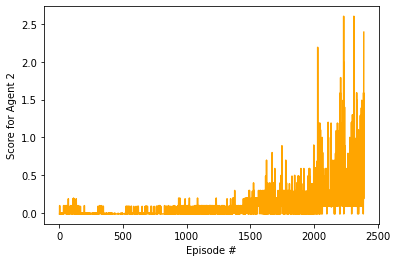

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(sc2)), sc2, c='orange')
plt.ylabel('Score for Agent 2')
plt.xlabel('Episode #')
plt.show()

## Watched Trained Agent

In [18]:
# load the weights from file
agent_1.actor_local.load_state_dict(torch.load('actor_checkpoint_1.pth', map_location={'cuda:0': 'cpu'}))
agent_1.critic_local.load_state_dict(torch.load('critic_checkpoint_1.pth', map_location={'cuda:0': 'cpu'}))

agent_2.actor_local.load_state_dict(torch.load('actor_checkpoint_2.pth', map_location={'cuda:0': 'cpu'}))
agent_2.critic_local.load_state_dict(torch.load('critic_checkpoint_2.pth', map_location={'cuda:0': 'cpu'}))

env_info = env.reset(train_mode=False)[brain_name] 
state = np.reshape(env_info.vector_observations, (1,48))            
score = np.zeros(2)                                          
while True:
    action_1 = agent_1.act(state)
    action_2 = agent_2.act(state)                      
    actions = np.concatenate((action_1, action_2), axis=0).flatten()
    env_info = env.step(actions)[brain_name]        
    next_state = np.reshape(env_info.vector_observations, (1,48))
    reward = env_info.rewards                   
    done = env_info.local_done                  
    score += reward                                
    state = next_state                             
    if np.any(done):
        break
    
print("Score: {}".format(score))

env.close()

Score: [0.50000001 0.39000001]
